In [53]:
# basic imports
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from tqdm.auto import tqdm # note: using tqdm.auto usually automatically chooses the right import based on whether you're in CLI, notebook or somewhere else
import itertools
import torch
from sklearn.metrics import mean_squared_error
from pykalman import KalmanFilter
import random
import os
from typing import Dict, Any, Sequence

from backtesting.trading_strategy import trade

from preprocessing.cointegration import find_cointegrated_pairs
from preprocessing.data_preprocessing import filter_pairs_data
from preprocessing.technical_indicators import combine_pairs_data
from preprocessing.filters import step_1_filter_remove_nans, step_2_filter_liquidity
from backtesting.trading_strategy import trade, get_gt_yoy_returns_test_dev
from utils.helpers import _get_train_dev_frac


## workflow imports
from models.statistical_models import execute_kalman_workflow, kalman_filter_average, kalman_filter_regression

## specific caching imports (should be changed in case you want to gather data live)
from data.scraper import load_cached_etf_tickers

# Any other changes to be made throughout the entire notebook
plt.style.use('seaborn-v0_8')

inspect_func = False
if inspect_func:
  import inspect
  print(inspect.getsource(execute_kalman_workflow)) # in this case, check whether the new trade function  is imported
### RESULTS IMPORTS ###

### HYPERPARAM OPTIMIZATION IMPORTS ###
## data gathering imports
from utils.helpers import _get_train_dev_frac
from preprocessing.filters import step_1_filter_remove_nans, step_2_filter_liquidity
from preprocessing.cointegration import find_cointegrated_pairs
from preprocessing.data_preprocessing import filter_pairs_data
from preprocessing.technical_indicators import combine_pairs_data
## specific caching imports (should be changed in case you want to gather data live)
from data.scraper import load_cached_etf_tickers
from data.data_collection_cache import gather_data_cached, gather_data_cached_using_truncate, gather_pairs_data_cached, save_pairs_data_filtered

from utils.helpers import return_score
### HYPERPARAM OPTIMIZATION IMPORTS ###

# Define trading func and resulting funcs

In [54]:
def trade(
        S1: pd.Series,
        S2: pd.Series,
        spread: pd.Series, # model-predicted spread for the strategy
        window_long: int,
        window_short: int,
        position_threshold: float = 1.0,
        clearing_threshold: float = 0.5,
        risk_fraction: float = 0.1 # could be used again
    ):   
    if len(spread) != len(S1) or len(spread) != len(S2):
        raise ValueError("Length of S1, S2, and spread must be the same")
    # Compute rolling mean and rolling standard deviation

    ma_long = spread.rolling(window=window_long, center=False).mean()
    ma_short = spread.rolling(window=window_short, center=False).mean()
    std = spread.rolling(window=window_short, center=False).std()
    zscore = (ma_long - ma_short)/std

    # Calculate initial cash based on average range of S1, S2 and Spread_Close, as these also determine the size of the trades
    s2_spread = max(S2) - min(S2)
    s1_spread = max(S1) - min(S1)
    spread_spread = max(spread) - min(spread)
    avg_spread = (s2_spread + s1_spread + spread_spread) / 3
    initial_cash = avg_spread * len(spread) # the absolute returns are correlated to the length of the spread, times the average range.

    # Simulate trading
    # Start with no money and no positions
    cash = initial_cash # initial cash amount, perhaps not hardcoded in the future
    qty_s1 = 0
    qty_s2 = 0
    returns = [initial_cash]

    for i in range(len(spread)):
        # Sell short if the z-score is > 1
        if zscore.iloc[i] > position_threshold:
            # print(f"[NEW] Step {i}: SELL SHORT, z={zscore.iloc[i]:.2f}, S1={S1.iloc[i]:.2f}, S2={S2.iloc[i]:.2f}, spread={spread.iloc[i]:.2f}, cash={cash:.2f}, qty_s1={qty_s1}, qty_s2={qty_s2}")
            cash += S1.iloc[i] - S2.iloc[i] * spread.iloc[i]
            qty_s1 -= 1
            qty_s2 += spread.iloc[i]
        # Buy long if the z-score is < 1
        elif zscore.iloc[i] < -position_threshold:
            # print(f"[NEW] Step {i}: BUY LONG, z={zscore.iloc[i]:.2f}, S1={S1.iloc[i]:.2f}, S2={S2.iloc[i]:.2f}, spread={spread.iloc[i]:.2f}, cash={cash:.2f}, qty_s1={qty_s1}, qty_s2={qty_s2}")
            cash -= S1.iloc[i] - S2.iloc[i] * spread.iloc[i]
            qty_s1 += 1
            qty_s2 -= spread.iloc[i]
        # Clear positions if the z-score between -.5 and .5
        elif abs(zscore.iloc[i]) < clearing_threshold:
            # print(f"[NEW] Step {i}: CLEAR POSITION, z={zscore.iloc[i]:.2f}, S1={S1.iloc[i]:.2f}, S2={S2.iloc[i]:.2f}, spread={spread.iloc[i]:.2f}, cash={cash:.2f}, qty_s1={qty_s1}, qty_s2={qty_s2}")
            cash += qty_s1 * S1.iloc[i] - S2.iloc[i] * qty_s2
            qty_s1 = 0
            qty_s2 = 0
        returns.append(cash) # append the current cash value to returns
    # If at any point returns is 0, all values after that is zero
    zero_from_this_idx = -1
    for i in range(len(returns)):
        if returns[i] <= 0:
            zero_from_this_idx = i
            break
    if zero_from_this_idx > -1:
        returns[zero_from_this_idx:] = [0] * (len(returns) - zero_from_this_idx)
    
    # Shrink returns by a factor such that returns are not inflated (more explanation given in methodology).
    returns_series = pd.Series(returns)
    alpha = 0.1  # Shrinking/stretching factor
    returns_uninflated = returns_series.copy()
    mask_positive = returns_series > initial_cash
    returns_uninflated[mask_positive] = initial_cash + alpha * (returns_series[mask_positive] - initial_cash)

    beta = 0.005
    mask_negative = (returns_series < initial_cash) & (returns_series > 0) # in case of total loss of equity, do not mask
    returns_uninflated[mask_negative] = initial_cash - beta * (initial_cash - returns_series[mask_negative])

    returns_uninflated = returns_uninflated.tolist()
    return returns_uninflated

def get_gt_yoy_returns_test_dev(pairs_timeseries_df, dev_frac, train_frac, look_back, yearly_trading_days: int = 252):
  total_len = len(pairs_timeseries_df)
  train_size = int(total_len * train_frac)
  dev_size   = int(total_len * dev_frac)
  test_size  = total_len - train_size - dev_size # not used, but for clarity

  train = pairs_timeseries_df.iloc[:train_size]
  dev   = pairs_timeseries_df.iloc[train_size:train_size + dev_size]
  test  = pairs_timeseries_df.iloc[train_size + dev_size:]


  index_shortened = test.index[:len(test['Spread_Close'].values[look_back:])] # problem: test['S1_close'].iloc[look_back:] and testY_untr are the same.. So we should rather be using test
  spread_gt_series = pd.Series(test['Spread_Close'].values[look_back:], index=index_shortened)
  gt_returns_test = trade(
      S1 = test['S1_close'].iloc[look_back:],
      S2 = test['S2_close'].iloc[look_back:],
      spread = spread_gt_series,
      window_long = 30,
      window_short = 5,
      position_threshold = 3,
      clearing_threshold = 0.4
  )
  gt_yoy_test = ((gt_returns_test[-1] / gt_returns_test[0])**(yearly_trading_days / len(gt_returns_test)) - 1)

  index_shortened = dev.index[:len(dev['Spread_Close'].values[look_back:])]
  spread_gt_series = pd.Series(dev['Spread_Close'].values[look_back:], index=index_shortened)
  gt_returns_dev = trade(
      S1 = dev['S1_close'].iloc[look_back:],
      S2 = dev['S2_close'].iloc[look_back:],
      spread = spread_gt_series,
      window_long = 30,
      window_short = 5,
      position_threshold = 3,
      clearing_threshold = 0.4
  )
  gt_yoy_dev = ((gt_returns_dev[-1] / gt_returns_dev[0])**(yearly_trading_days / len(gt_returns_dev)) - 1)
  return {
      "gt_yoy_test": gt_yoy_test, 
      "gt_yoy_dev": gt_yoy_dev
  }
  

def calculate_return_uncertainty(S1, S2, spread_pred_series, position_thresholds=None, clearing_thresholds=None,
                          long_windows=None, short_windows=None, yearly_trading_days=252, return_for_plotting=False):
  if position_thresholds is not None and clearing_thresholds is not None:
      threshold_combinations = list(itertools.product(position_thresholds, clearing_thresholds))
      param_type = 'thresholds'
  elif long_windows is not None and short_windows is not None:
      threshold_combinations = list(itertools.product(long_windows, short_windows))
      param_type = 'windows'
  else:
      raise ValueError("Must specify either (position_thresholds and clearing_thresholds) or (long_windows and short_windows)")

  all_returns = []

  for a, b in threshold_combinations:
      if param_type == 'thresholds':
          returns = trade(
              S1=S1,
              S2=S2,
              spread=spread_pred_series,
              window_long=30,
              window_short=5,
              position_threshold=a,
              clearing_threshold=b
          )
          # print(f"Returns for (pt={a},ct={b}) -> {returns[-1]}")
      else:
          returns = trade(
              S1=S1,
              S2=S2,
              spread=spread_pred_series,
              window_long=a,
              window_short=b,
              position_threshold=0.8,
              clearing_threshold=0.2
          )
          # print(f"Returns for (wl={a},ws={b}) -> {returns[-1]}")

      all_returns.append(returns)

  # turn into numpy
  returns_array = np.vstack([np.array(r) for r in all_returns])

  # mean and stdev for plotting
  mean_returns = returns_array.mean(axis=0)
  std_returns = returns_array.std(axis=0)
  std_dev_pct = (std_returns / mean_returns[0]) * 100
  if return_for_plotting:
    return np.vstack([np.array(r) for r in all_returns]), param_type
  return ((mean_returns[-1] / mean_returns[0])**(yearly_trading_days / len(mean_returns)) - 1), ((std_returns[-1] / mean_returns[0]) * np.sqrt(yearly_trading_days / len(mean_returns)))


def execute_kalman_workflow(
  pairs_timeseries: pd.DataFrame,
  target_col: str = "Spread_Close",
  col_s1: str = "S1_close",
  col_s2: str = "S2_close",
  train_frac: float = 0.90,
  dev_frac: float = 0.05,
  seed: int = 3178749, # for reproducibility, my student number
  look_back: int = 1,
  yearly_trading_days: int = 252,
  ## optimized hyperparams ##
  delta: float = 1e-3,
  obs_cov_reg: float = 2.,
  trans_cov_avg: float = 0.01,
  obs_cov_avg: float = 1.,
  ## optimized hyperparams ##
  return_datasets: bool = False,
  verbose: bool = True,
  result_parent_dir: str = "data/results",
  filename_base: str = "data_begindate_enddate_hash.pkl", # use `_get_filename(startDateStr, endDateStr, instrumentIds)`
  pair_tup_str: str = "(?,?)", # Used for showing which tuple was used in plots, example: "(QQQ, SPY)"
):
  # Set seeds
  torch.manual_seed(seed)
  np.random.seed(seed)
  random.seed(seed)

  # For GPU (if used)
  if torch.cuda.is_available():
      torch.cuda.manual_seed(seed)
      torch.cuda.manual_seed_all(seed)
      torch.backends.cudnn.deterministic = True
      torch.backends.cudnn.benchmark = False  # Might slow down, but ensures determinism
      
  # Check whether everything is present as expected (good practice, and gives useful exceptions)
  required = {col_s1, col_s2}
  if not required.issubset(pairs_timeseries.columns):
      raise KeyError(f"pairs_timeseries must contain {required}")

  total_len = len(pairs_timeseries)
  train_size = int(total_len * train_frac)
  dev_size   = int(total_len * dev_frac)
  test_size  = total_len - train_size - dev_size # not used, but for clarity

  train_univariate = pairs_timeseries.iloc[:train_size][target_col]
  dev_univariate = pairs_timeseries.iloc[train_size:train_size + dev_size][target_col]
  test_univariate = pairs_timeseries.iloc[train_size + dev_size:][target_col]
  
  train_multivariate = pairs_timeseries.iloc[:train_size]
  dev_multivariate = pairs_timeseries.iloc[train_size:train_size + dev_size]
  test_multivariate = pairs_timeseries.iloc[train_size + dev_size:]  
  
  if verbose:
      print(f"Split sizes — train: {len(train_univariate)}, dev: {len(dev_univariate)}, test: {len(test_univariate)}")
      
  beta_t_train = - kalman_filter_regression(
      kalman_filter_average(train_multivariate[col_s1],
                            transition_cov=trans_cov_avg,
                            obs_cov=obs_cov_avg),
      kalman_filter_average(train_multivariate[col_s2],
                            transition_cov=trans_cov_avg,
                            obs_cov=obs_cov_avg),
      delta=delta,
      obs_cov=obs_cov_reg
  )[:, 0]
  forecast_train_raw = train_multivariate[col_s1] + train_multivariate[col_s2] * beta_t_train # merely used for scaling dev without lookahead bias
      
  # get dev forecasts
  beta_t_dev = - kalman_filter_regression(
      kalman_filter_average(dev_multivariate[col_s1],
                            transition_cov=trans_cov_avg,
                            obs_cov=obs_cov_avg),
      kalman_filter_average(dev_multivariate[col_s2],
                            transition_cov=trans_cov_avg,
                            obs_cov=obs_cov_avg),
      delta=delta,
      obs_cov=obs_cov_reg
  )[:, 0]
  forecast_dev_raw = dev_multivariate[col_s1] + dev_multivariate[col_s2] * beta_t_dev
  forecast_dev = (forecast_dev_raw - forecast_train_raw.mean()) / forecast_train_raw.std()

  # get test forecasts
  beta_t_test = - kalman_filter_regression(
      kalman_filter_average(test_multivariate[col_s1],
                            transition_cov=trans_cov_avg,
                            obs_cov=obs_cov_avg),
      kalman_filter_average(test_multivariate[col_s2],
                            transition_cov=trans_cov_avg,
                            obs_cov=obs_cov_avg),
      delta=delta,
      obs_cov=obs_cov_reg
  )[:, 0]
  forecast_test_raw = test_multivariate[col_s1] + test_multivariate[col_s2] * beta_t_test
  forecast_test = (forecast_test_raw - forecast_dev_raw.mean()) / forecast_dev_raw.std()
  
  beta_t_full = - kalman_filter_regression(
      kalman_filter_average(pairs_timeseries[col_s1],
                            transition_cov=trans_cov_avg,
                            obs_cov=obs_cov_avg),
      kalman_filter_average(pairs_timeseries[col_s2],
                            transition_cov=trans_cov_avg,
                            obs_cov=obs_cov_avg),
      delta=delta,
      obs_cov=obs_cov_reg
  )[:, 0]
  forecast_full_raw = pairs_timeseries[col_s1] + pairs_timeseries[col_s2] * beta_t_full
  forecast_full = (forecast_full_raw - forecast_full_raw.mean()) / forecast_full_raw.std()

  if look_back == 1:
      # Calculate mse values
      test_mse = mean_squared_error(test_univariate, forecast_test)
      test_var = np.var(test_univariate)
      test_nmse = test_mse / test_var if test_var != 0 else 0.0

      # also for validation
      val_mse = mean_squared_error(dev_univariate, forecast_dev)
      val_var = np.var(dev_univariate)
      val_nmse = val_mse / val_var if val_var != 0 else 0.
  else:
      raise NotImplementedError("Warning: look_back > 1 not yet implemented. Returning None for mse.")

  ### TRADING ###
  # calculate std_dev_pct using the logic from plot_with_uncertainty. Then put that into two separate functions: calculate_yoy_uncertainty and a version of plot_with_uncertainty that uses calculate_yoy_uncertainty
  # position threshold (2.00-4.00), clearing threshold (0.30-0.70)
  min_position = 2.00
  max_position = 4.00
  min_clearing = 0.30
  max_clearing = 0.70
  position_thresholds = np.linspace(min_position, max_position, num=10)
  clearing_thresholds = np.linspace(min_clearing, max_clearing, num=10)

  test_s1 = test_multivariate['S1_close']
  test_s2 = test_multivariate['S2_close']

  yoy_mean, yoy_std = calculate_return_uncertainty(test_s1, test_s2, forecast_test, position_thresholds=position_thresholds, clearing_thresholds=clearing_thresholds)
  # calculate the strategy returns if we were to feed the groundtruth values to the `trade` func. If the ground truth returns are lower, it seems likely there is something wrong with the `trade` func (but not certain! Probability applies here).
  output = get_gt_yoy_returns_test_dev(pairs_timeseries, dev_frac, train_frac, look_back=0, yearly_trading_days=yearly_trading_days)
  gt_yoy, gt_yoy_for_dev_dataset = output['gt_yoy_test'], output['gt_yoy_dev']
  
  current_result_dir = filename_base.replace(".pkl", "_kalman")
  result_dir = os.path.join(result_parent_dir, current_result_dir)
  if not os.path.exists(result_dir):
      os.makedirs(result_dir)
      
  output: Dict[str, Any] = dict(
      val_mse=val_nmse,
      test_mse=test_nmse,
      yoy_mean=yoy_mean,
      yoy_std=yoy_std,
      gt_yoy=gt_yoy,
      result_parent_dir=result_parent_dir,
  )
  
  results_str = f"""
Validation MSE: {output['val_mse']}
Test MSE: {output['test_mse']}
YOY Returns: {output['yoy_mean'] * 100:.2f}%
YOY Std: +- {output['yoy_std'] * 100:.2f}%
GT Yoy: {output['gt_yoy'] * 100:.2f}%
Plot filepath parent dir: {output['result_parent_dir']}
pair_tup_str: {pair_tup_str}
  """
  with open(os.path.join(result_dir, "results.txt"), "w") as f:
      f.write(results_str)
  if verbose:
    print(results_str)
  if return_datasets:
      output.update(
          dict(
            pairs_timeseries=pairs_timeseries,
            test_s1_shortened=test_s1, 
            test_s2_shortened=test_s2,
            forecast_train=(forecast_train_raw - forecast_train_raw.mean()) / forecast_train_raw.std(), 
            forecast_dev=forecast_dev,
            forecast_old_method=forecast_full, # has lookahead bias
            forecast_test_shortened_series=forecast_test, 
            gt_test_shortened_series=test_univariate
          )
      )  
  return output


# Gather Results using new specific trading func

In [55]:
return_datasets = True
verbose = True

In [56]:
# Hard code hyperparameters based on results above
hyperparam_kwargs = {'delta': 0.014784091621725818, 'obs_cov_reg': 2.5600560664086465, 'trans_cov_avg': 0.09999999999999999, 'obs_cov_avg': 3.4796803986835676}

results_all_years = {}
outputs_all_years = {}
for end_year in [2020, 2021, 2022, 2023, 2024][:1]:
  ### Year-specific data ###
  startDateStr = '2008-01-01'
  endDateStr = f'{end_year}-12-31'
  startDateStrTest = f'{end_year}-01-01'
  endDateStrTest = f'{end_year}-12-31'
  train_frac, dev_frac = _get_train_dev_frac(startDateStr, endDateStr, startDateStrTest, endDateStrTest)

  instrumentIdsNASDAQandNYSE = load_cached_etf_tickers()
  data = gather_data_cached_using_truncate(startDateStr, endDateStr, instrumentIdsNASDAQandNYSE, cache_dir='../src/data/cache')
  data_close_filtered_1, data_open_filtered_1, data_high_filtered_1, data_low_filtered_1, data_vol_filtered_1, data_original_format_filtered_1 = step_1_filter_remove_nans(data['close'], data['open'], data['high'], data['low'], data['vol'], data)
  data_close_filtered_2, data_open_filtered_2, data_high_filtered_2, data_low_filtered_2, data_vol_filtered_2, data_original_format_filtered_2 = step_2_filter_liquidity(data_close_filtered_1, data_open_filtered_1, data_high_filtered_1, data_low_filtered_1, data_vol_filtered_1, data_original_format_filtered_1)

  pairs_data_filtered = gather_pairs_data_cached(startDateStr, endDateStr, instrumentIdsNASDAQandNYSE, cache_dir='../src/data/cache')
  if pairs_data_filtered is None:
    scores, pvalues, pairs = find_cointegrated_pairs(data_original_format_filtered_2)
    pairs_data = {key:value[1]  for (key, value) in pairs.items()}
    pairs_data = sorted(pairs_data.items(), key=lambda x: x[1])
    pairs_data_filtered = filter_pairs_data(pairs_data) # filter based on cointegration in such a way that we can simply pick the highest pair of stocks in the list.
    save_pairs_data_filtered(pairs_data_filtered, startDateStr, endDateStr, instrumentIdsNASDAQandNYSE, cache_dir='../src/data/cache')
  ### Year-specific data ###

  ### OPTIONAL: define worfklow here for debugging ###

  ### OPTIONAL: define worfklow here for debugging ###

  # Gather results for current_year
  results_kalman_current_year = []
  all_outputs_kalman_current_year = []
  num_results = min(len(pairs_data_filtered), 15)
  for i in tqdm(range(num_results), desc = "Gathering [...]"):
      ticker_a, ticker_b = pairs_data_filtered[i][0][0], pairs_data_filtered[i][0][1]
      pair_tup_str_current = f"({ticker_a},{ticker_b})"
      pairs_timeseries_df = combine_pairs_data(data_close_filtered_2, data_open_filtered_2, data_high_filtered_2, data_low_filtered_2, data_vol_filtered_2, ticker_a, ticker_b)
      output_returns = get_gt_yoy_returns_test_dev(pairs_timeseries_df, dev_frac, train_frac, look_back=20)
      gt_yoy, gt_yoy_for_dev_dataset = output_returns['gt_yoy_test'], output_returns['gt_yoy_dev']
      output_model = execute_kalman_workflow(pairs_timeseries_df, verbose=verbose, pair_tup_str=pair_tup_str_current, train_frac=train_frac, dev_frac=dev_frac, return_datasets=return_datasets, **hyperparam_kwargs)     
      # print(output_model
      yoy_str = f"{output_model['yoy_mean'] * 100:.2f}% +- {output_model['yoy_std'] * 100:.2f}%"
      returns_score = return_score(output_model['yoy_mean'], gt_yoy)
      cointegration_score = pairs_data_filtered[i][1]
      results_kalman_current_year.append((pair_tup_str_current, cointegration_score, output_model['val_mse'], output_model['test_mse'], yoy_str, gt_yoy, returns_score)) # (pair, cointegration_score, val, test, yoy_str, gt_yoy, returns_score)
      all_outputs_kalman_current_year.append(output_model)
  results_all_years[end_year] = results_kalman_current_year
  outputs_all_years[end_year] = all_outputs_kalman_current_year

Gathering [...]:   0%|          | 0/15 [00:00<?, ?it/s]

Split sizes — train: 2769, dev: 251, test: 253

Validation MSE: 3.6243235576283928
Test MSE: 6.248608346968328
YOY Returns: 161.05%
YOY Std: +- 11.31%
GT Yoy: 739.64%
Plot filepath parent dir: data/results
pair_tup_str: (SHV,SMH)
  
Split sizes — train: 2769, dev: 251, test: 253

Validation MSE: 14.379142325300098
Test MSE: 7.310138644456767
YOY Returns: 188.92%
YOY Std: +- 12.69%
GT Yoy: 554.64%
Plot filepath parent dir: data/results
pair_tup_str: (SHV,ONEQ)
  
Split sizes — train: 2769, dev: 251, test: 253

Validation MSE: 12.987513302044722
Test MSE: 8.91064752461116
YOY Returns: 92.83%
YOY Std: +- 4.60%
GT Yoy: 330.65%
Plot filepath parent dir: data/results
pair_tup_str: (SHV,PHO)
  
Split sizes — train: 2769, dev: 251, test: 253

Validation MSE: 12.110528150339782
Test MSE: 7.176724105279739
YOY Returns: 144.76%
YOY Std: +- 16.51%
GT Yoy: 654.93%
Plot filepath parent dir: data/results
pair_tup_str: (SHV,PDP)
  
Split sizes — train: 2769, dev: 251, test: 253

Validation MSE: 14.020

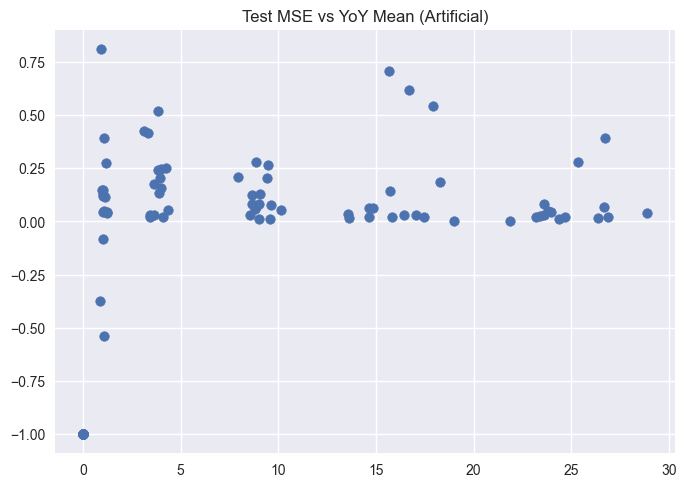

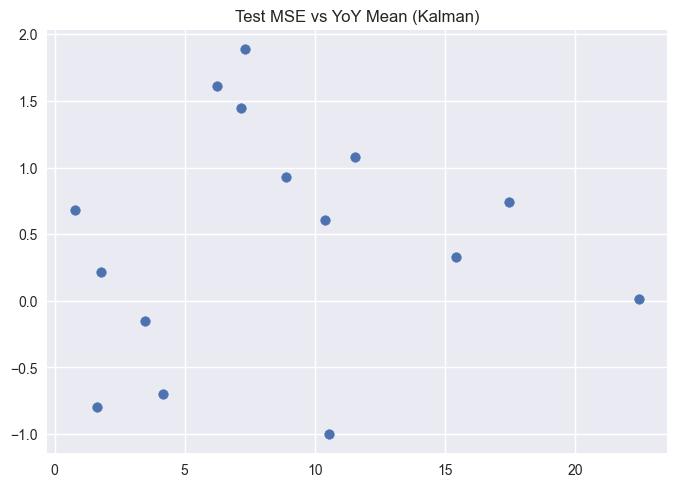

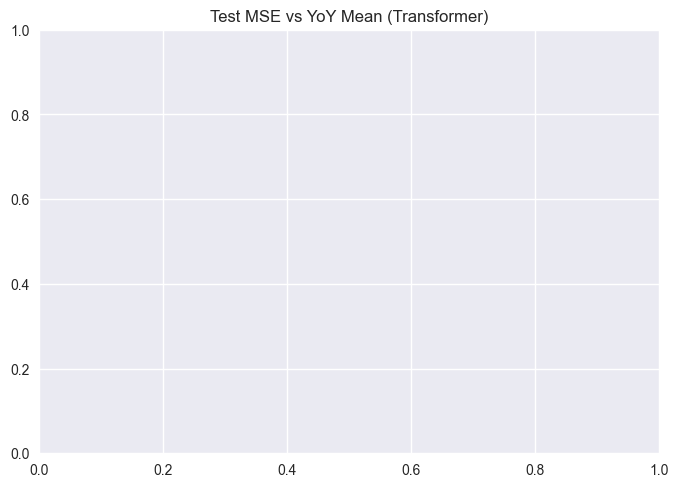

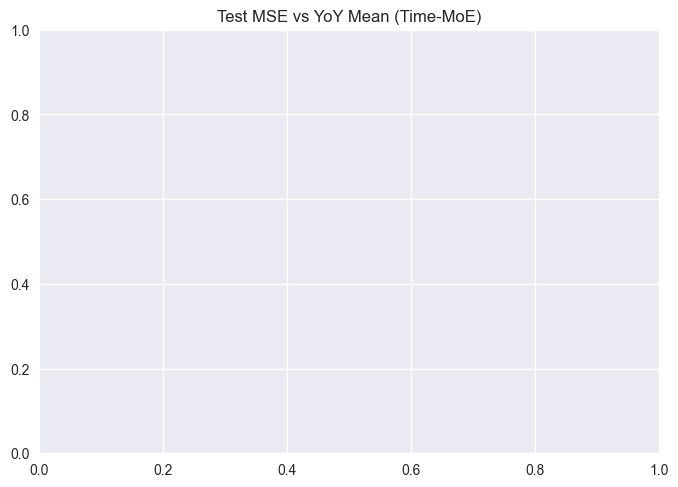

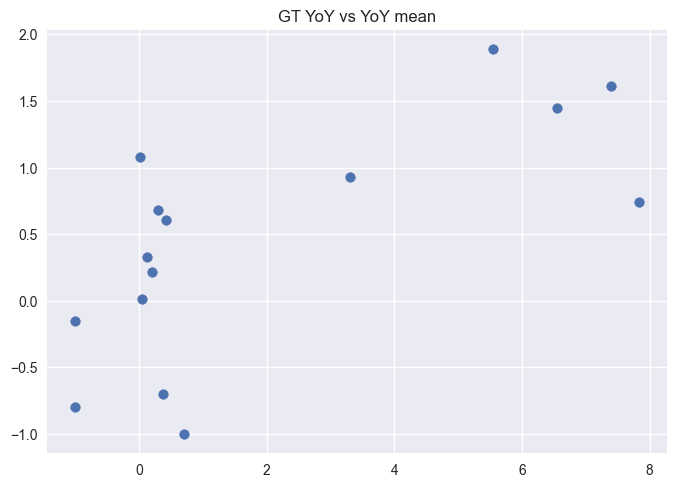

In [57]:
min_position = 2.00
max_position = 4.00
min_clearing = 0.30
max_clearing = 0.70
position_thresholds = np.linspace(min_position, max_position, num=5)
clearing_thresholds = np.linspace(min_clearing, max_clearing, num=5)

def return_score(yoy_mean, yoy_std, gt_yoy):
  abs_diff = abs(yoy_mean - gt_yoy)
  if gt_yoy == -1:
    return np.nan
  if yoy_mean == -1:
    return -1
  abs_diff = abs(yoy_mean - gt_yoy)
  rs = ((0.1 + (yoy_mean - yoy_std)) / (0.1 + gt_yoy))
  return round(rs, 2)

test_mse_list, yoy_mean_list, return_score_list,gt_yoy_list, test_mse_artificial_list, yoy_mean_artificial_list  = [], [], [], [], [], []
for year, output_dict in outputs_all_years.items():
  for output in output_dict:
    # add test_mse_artificial and yoy_mean_artificial to output_model
    for std_dev in [0.1, 1, 2, 3, 4, 5]:
        test_univariate = output_model['gt_test_shortened_series']
        noise = np.random.normal(loc=0, scale=std_dev, size=len(test_univariate))
        test_univariate_artificial_noise = test_univariate + noise
        # note: you might want to rerun the definition of calculate_return_uncertainty before executing this, because changes don't automatically propagate
        yoy_mean_artificial, _ = calculate_return_uncertainty(output['test_s1_shortened'], output['test_s2_shortened'], test_univariate_artificial_noise, position_thresholds=position_thresholds, clearing_thresholds=clearing_thresholds)
        test_mse_artificial = mean_squared_error(test_univariate, test_univariate_artificial_noise)
        test_mse_artificial_list.append(test_mse_artificial)
        yoy_mean_artificial_list.append(yoy_mean_artificial)
    
    test_mse_list.append(output['test_mse'])
    yoy_mean_list.append(output['yoy_mean'])
    gt_yoy_list.append(output['gt_yoy'])
    return_score_current = return_score(output['yoy_mean'], output['yoy_std'], output['gt_yoy'])
    return_score_list.append(return_score_current)

plt.title("Test MSE vs YoY Mean (Artificial)")
plt.scatter(test_mse_artificial_list, yoy_mean_artificial_list)
plt.show()

plt.title("Test MSE vs YoY Mean (Kalman)")
plt.scatter(test_mse_list, yoy_mean_list)
plt.show()

plt.title("Test MSE vs YoY Mean (Transformer)")
plt.show()

plt.title("Test MSE vs YoY Mean (Time-MoE)")
plt.show()

plt.title("GT YoY vs YoY mean")
plt.scatter(gt_yoy_list, yoy_mean_list)
plt.show()